In [1]:
# Import Dependencies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel
from sklearn.kernel_ridge import KernelRidge

### Midterm 1 Project, Problem 2-5

Optimized Kernel from GP: ExpSineSquared(length_scale=1.84, periodicity=6.45) + WhiteKernel(noise_level=0.14)
Penalty Coefficient for KRR (λ): 0.14048207773059232


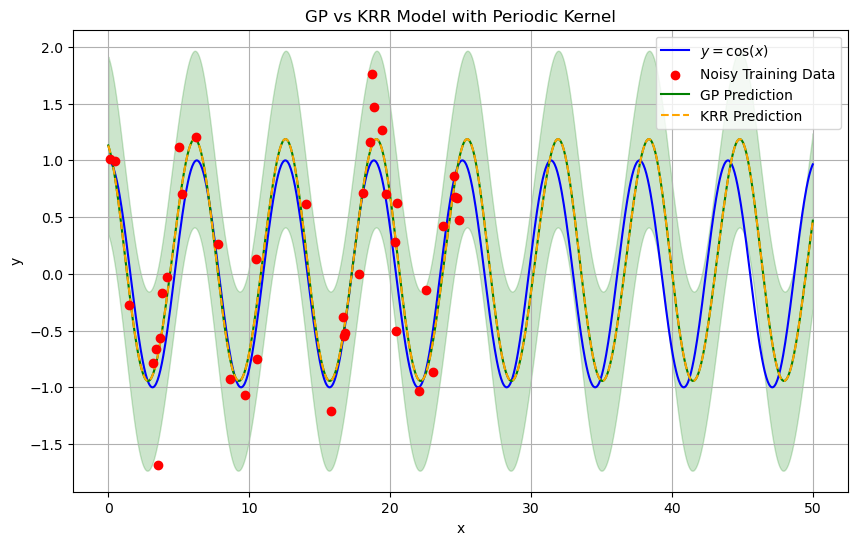

In [2]:
# Part 1: Generate noisy data as done previously
x = np.linspace(0, 50, 1000)  # Generate 1000 evenly spaced x data points
y_true = np.cos(x)  # True function y = cos(x)

# Randomly select 40 points from the first 500 data points
np.random.seed(42)  # Ensure reproducibility
indices = np.random.choice(np.arange(500), size=40, replace=False)

# Add i.i.d. random noise (mean 0, variance 0.16) to the 40 selected points
noise = np.random.normal(0, np.sqrt(0.16), size=40)
x_train = x[indices].reshape(-1, 1)  # Select 40 x points from the first 500
y_train_noisy = y_true[indices] + noise  # Add noise to the corresponding y points

# Part 2: Fit a Gaussian Process (GP) model using a periodic kernel and a white noise kernel
# Define the kernel: periodic kernel (ExpSineSquared) + white noise (WhiteKernel)
kernel = ExpSineSquared(length_scale=1.0, periodicity=1.0) + WhiteKernel(noise_level=1.0)

# Create the Gaussian Process Regressor with the specified kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the GP to the noisy data
gp.fit(x_train, y_train_noisy)

# Predict using the GP on the full x range
x_pred = x.reshape(-1, 1)
y_pred_gp, y_std_gp = gp.predict(x_pred, return_std=True)

# Extract the learned kernel hyperparameters from the GP model
kernel_optimized = gp.kernel_
print("Optimized Kernel from GP:", kernel_optimized)

# Extract the optimized periodic kernel hyperparameters (from GP model)
periodicity = kernel_optimized.k1.periodicity
length_scale = kernel_optimized.k1.length_scale

# Part 3: Kernel Ridge Regression (KRR)
# Use the same periodic kernel hyperparameters as in the GP model
krr_kernel = ExpSineSquared(length_scale=length_scale, periodicity=periodicity)

# Choose the penalty coefficient (regularization parameter)
# Use a value similar to the noise variance in GP model to match the GP's posterior mean
penalty_coefficient = kernel_optimized.k2.noise_level
print(f"Penalty Coefficient for KRR (λ): {penalty_coefficient}")

# Fit the KRR model
krr = KernelRidge(kernel=krr_kernel, alpha=penalty_coefficient)
krr.fit(x_train, y_train_noisy)

# Predict using the KRR model
y_pred_krr = krr.predict(x_pred)

# Plot the results with the GP and KRR
plt.figure(figsize=(10, 6))

# Plot the true function y = cos(x)
plt.plot(x, y_true, label=r"$y = \cos(x)$", color='blue')

# Plot the noisy training data points
plt.scatter(x_train, y_train_noisy, label="Noisy Training Data", color='red', zorder=5)

# Plot the GP predictions with uncertainty bounds
plt.plot(x_pred, y_pred_gp, label="GP Prediction", color='green')
plt.fill_between(x_pred.flatten(), y_pred_gp - 1.96 * y_std_gp, y_pred_gp + 1.96 * y_std_gp, alpha=0.2, color='green')

# Plot the KRR predictions
plt.plot(x_pred, y_pred_krr, label="KRR Prediction", color='orange', linestyle='--')

# Optionally, you can fill KRR area based on GP's uncertainty for visualization purposes (but this is still GP uncertainty)
#plt.fill_between(x_pred.flatten(), y_pred_krr - 1.96 * y_std_gp, y_pred_krr + 1.96 * y_std_gp, alpha=0.2, color='orange')

# Set labels, title, and legend
plt.title("GP vs KRR Model with Periodic Kernel")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()